vf 03: Classificação se é fato gerador ou não e da categoria (SE, CI, CA) de uma só fez (4 categorias: NÃO, SE, CI, CA) e em 2 etapas, utilizando TF-IDF com limpeza de dados, balanceamento de classes, otimização de hiperparâmetros com cross validation do algoritimo LogisticRegression.

# Classificação de lançamentos contábeis

1) Descrição do problema: classificar a despesa pública natureza 339036 (outros serviços - pessoa física) com base no histórico da nota de empenho como fato gerador, ou não, das contribuições previdenciárias.

2) Descrição da solução: Construção de features com base no texto do histórico das notas de empenho, treinamento e teste para seleção do modelo de classificação com melhor métrica de desempenho.

3) Fonte de dados: Os dados das notas de empenho estão disponíveis em portais da transparência de diversos órgãos públicos, por exemplo,
https://www.governotransparente.com.br/acessoinfo/44529487/empenhoportipo. No caso, será utilizada uma base de dados rotulados a partir desses dados públicos.

4) Variáveis independentes: texto com o histórico da nota de empenho.

5) Variável dependente. Primeiramente, será classificado apenas como 0 (não é fato gerador) e 1 (é fato gerador). Posteriormente, a classificação incluirá a categoria do segurado: segurado empregado, contribuinte individual, contribuinte individual – condutor autônomo.

## 1. Carregamento dos dados e importação das bibliotecas

In [1]:
# Monta google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carrega os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importa bibliotecas
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.inspection import permutation_importance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import joblib

# Configurações
pd.set_option('display.max_colwidth', None)

In [ ]:
# Importa os dados
df_completo = pd.read_json('/content/drive/My Drive/projeto classificacao de lancamento/dados/despesa liquidada - base completa - texto processado - balanceado.json')
df_completo.head()

In [ ]:
# Construção de dataframe com as colunas de interesse
df = df_completo[['descricao_lematizada', 'fato_gerador', 'categoria']]
df.head()

In [ ]:
df['categoria'].value_counts()

## 2. Classificação em 1 etapa (fato gerador e categoria simultaneamente)

### 2.1. Otimização de hiperparâmetros

In [ ]:
%%time
# Amostra de 8000 observações
df_sample = df.sample(8000, random_state=42)

# Separação entre variáveis preditoras e alvo e divisão em treino e teste
X = df_sample['descricao_lematizada']
y = df_sample['categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Definição dos hiperparâmetros para o Grid Search
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

# Pipeline com TF-IDF e regressão logística
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(solver='saga', max_iter=3000, random_state=42))
])

# Busca de hiperparâmetros com validação cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_
print("Melhores hiperparâmetros:", grid_search.best_params_)

# Acurácia do melhor classificador
print(f"F1-Score do melhor modelo: {grid_search.best_score_:.6f}")

Melhores hiperparâmetros: {'classifier__C': 100, 'classifier__penalty': 'l1', 'tfidf__ngram_range': (1, 1)}
F1-Score do melhor modelo: 0.990807
CPU times: user 34.1 s, sys: 929 ms, total: 35 s
Wall time: 7min 41s


### 2.2. Avaliação do modelo

F1-Score balanceado: 0.9964175511214911
              precision    recall  f1-score   support

          CA       0.99      0.99      0.99       627
          CI       1.00      1.00      1.00      8478
         Não       1.00      1.00      1.00      2362
          SE       0.90      1.00      0.95       146

    accuracy                           1.00     11613
   macro avg       0.97      1.00      0.98     11613
weighted avg       1.00      1.00      1.00     11613



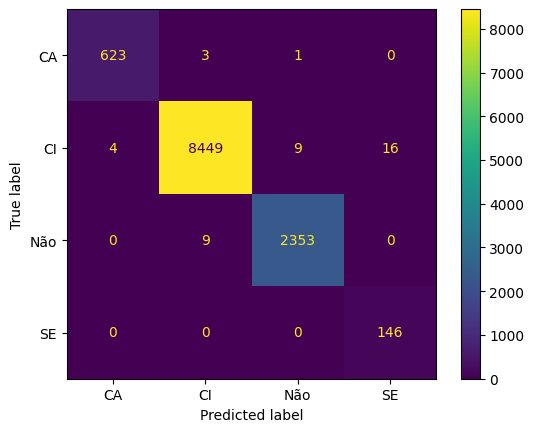

In [ ]:
# Recuperação do dataset completo e divisão em treino e teste
X = df['descricao_lematizada']
y = df['categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Ajuste do modelo e predição
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Avaliação
print("F1-Score balanceado:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### 2.3. Análise das predições do modelo

In [ ]:
# Cálculo das probabilidades de cada classe
prob_pred = best_model.predict_proba(X_test)

# Construção de dataframe para conferência das previsões e respectivas probabilidades
df_check = pd.DataFrame(X_test)
df_check['target'] = y_test
df_check['prediction'] = y_pred
df_check['prob_CA'] = np.round(prob_pred[0:,0],6).tolist()
df_check['prob_CI'] = np.round(prob_pred[0:,1],6).tolist()
df_check['prob_Não'] = np.round(prob_pred[0:,2],6).tolist()
df_check['prob_SE'] = np.round(prob_pred[0:,3],6).tolist()

# Listar as previsões erradas
df_error = df_check[df_check['target'] != df_check['prediction']]
print('Quantidade de previsões erradas:', df_error.shape[0])
df_error

Quantidade de previsões erradas: 42


,descricao_lematizada,target,prediction,prob_CA,prob_CI,prob_Não,prob_SE
32130,carro alugar educação de este,Não,CI,0.043682,0.956021,0.000272,0.000026
685,logisticar saúde de este municipio,CA,CI,0.000045,0.999876,0.000066,0.000013
10367,contribuição financeiro conceder custear despesa taxa arbitragemo fefuspa onde acontecerar jogo selecao baionense futsal contra selecao Goianesia sera realizar Ginasio higino Ramos de este municipio,CI,Não,0.000151,0.064804,0.934966,0.000079
31219,empenho despesa serviço prestar aluguel som iluminação palco estrutura metálico demanr programa cra de este assistência social evento Rosa azul,Não,CI,0.000426,0.975531,0.023924,0.000119
38011,contribuicao financeiro concedir custear despesa realizacao rodar jogo Selecao baionense campeonato paraense futsal realizar dia quadra higino Ramos de este municipio,Não,CI,0.000890,0.551199,0.447457,0.000454
8564,digitador setor contábil relacionar rede,CI,SE,0.000006,0.465704,0.000032,0.534258
11367,digitador setor contábil relacionar rede,CI,SE,0.000006,0.465704,0.000032,0.534258
33622,premiação i concurso miss caipira junina virtual realizar cultura,Não,CI,0.000010,0.999720,0.000262,0.000007
19013,ser marceneiro fornecimento material divisoria casa onde ir funcionar sede seab urbanismo,CI,Não,0.007662,0.013051,0.979244,0.000043
7760,digitador setor contábil relacionar rede,CI,SE,0.000006,0.465704,0.000032,0.534258


## 3. Classificação em 2 etapas (primeiro fato gerador, depois categoria)

### 3.1. Classificação de fato gerador

#### 3.1.1. Otimização de hiperparâmetros

In [ ]:
%%time
# Dataframe de teste para determinação das melhores técnicas de processamento de texto e melhores hyperparâmetros.
# O método sample estratifica o dataframe proporcionalmente às classes.
df_sample = df.sample(8000, random_state=42)
df_train, df_test = train_test_split(df_sample, test_size=0.3, stratify=df_sample[['fato_gerador', 'categoria']], random_state=42)

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['fato_gerador']
X_test, y_test = df_test['descricao_lematizada'], df_test['fato_gerador']

# Definição dos hiperparâmetros para o Grid Search
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

# Pipeline com TF-IDF e regressão logística
pipeline_1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=3000, random_state=42))
])

# Busca de hiperparâmetros com validação cruzada
grid_search_1 = GridSearchCV(pipeline_1, param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search_1.fit(X_train, y_train)

# Melhor modelo encontrado
best_model_1 = grid_search_1.best_estimator_
print(f"Melhores hiperparâmetros: {grid_search_1.best_params_}")

# Acurácia do melhor estimador
print(f"F1-Score: {grid_search_1.best_score_:.6f}")

Melhores hiperparâmetros: {'classifier__C': 10, 'classifier__penalty': 'l1', 'tfidf__ngram_range': (1, 2)}
F1-Score: 0.996246
CPU times: user 775 ms, sys: 52.2 ms, total: 828 ms
Wall time: 13.9 s


#### 3.1.2. Avaliação do modelo

F1-Score balanceado: 0.9982769761980791
              precision    recall  f1-score   support

         Não       1.00      0.99      1.00      2362
         Sim       1.00      1.00      1.00      9251

    accuracy                           1.00     11613
   macro avg       1.00      1.00      1.00     11613
weighted avg       1.00      1.00      1.00     11613



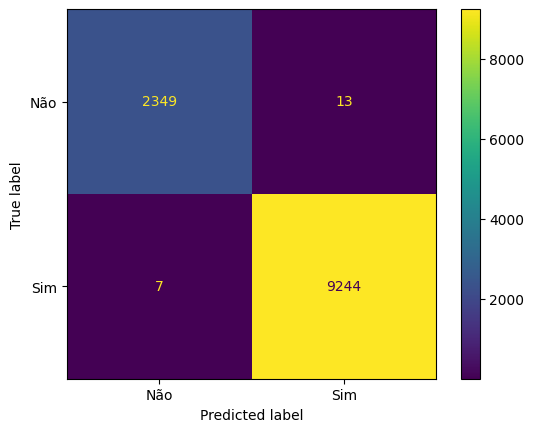

In [ ]:
# Recuperação do dataset completo e divisão em treino e teste
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['fato_gerador']
X_test, y_test = df_test['descricao_lematizada'], df_test['fato_gerador']

# Ajuste do modelo e predição
best_model_1.fit(X_train, y_train)
y_pred = best_model_1.predict(X_test)

# Avaliação
print("F1-Score balanceado:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### 3.2. Classificação de categoria

#### 3.2.1. Otimização de hiperparâmetros

In [ ]:
%%time
# Dataframe de teste para determinação das melhores técnicas de processamento de texto e melhores hyperparâmetros.
# O método sample estratifica o dataframe proporcionalmente às classes.
df_sample = df.sample(8000, random_state=42)
df_sample = df_sample[df_sample['fato_gerador'] == 'Sim']
df_train, df_test = train_test_split(df_sample, test_size=0.3, stratify=df_sample[['fato_gerador', 'categoria']], random_state=42)

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['categoria']
X_test, y_test = df_test['descricao_lematizada'], df_test['categoria']

# Definição dos hiperparâmetros para o Grid Search
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

# Pipeline com TF-IDF e regressão logística
pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(solver='saga', max_iter=3000, random_state=42))
])

# Busca de hiperparâmetros com validação cruzada
grid_search_2 = GridSearchCV(pipeline_2, param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search_2.fit(X_train, y_train)

# Melhor modelo encontrado
best_model_2 = grid_search_2.best_estimator_
print(f"Melhores hiperparâmetros: {grid_search_2.best_params_}")

# Acurácia do melhor estimador
print(f"F1-Score: {grid_search_2.best_score_:.6f}")

Melhores hiperparâmetros: {'classifier__C': 100, 'classifier__penalty': 'l2', 'tfidf__ngram_range': (1, 1)}
F1-Score: 0.991035
CPU times: user 3.39 s, sys: 406 ms, total: 3.8 s
Wall time: 3min 38s


#### 3.2.2. Avaliação do modelo

F1-Score balanceado: 0.9970211738417406
              precision    recall  f1-score   support

          CA       0.99      0.99      0.99       627
          CI       1.00      1.00      1.00      8478
          SE       0.90      1.00      0.94       146

    accuracy                           1.00      9251
   macro avg       0.96      1.00      0.98      9251
weighted avg       1.00      1.00      1.00      9251



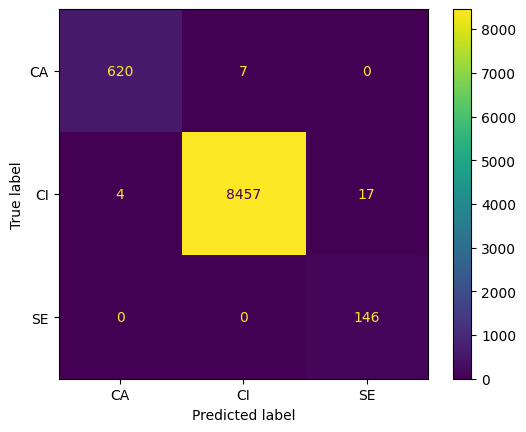

In [ ]:
# Recuperação do dataset completo, filtro das observações fato_gerador = 1
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)
df_train = df_train[df_train['fato_gerador'] == 'Sim']
df_test = df_test[df_test['fato_gerador'] == 'Sim']

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['categoria']
X_test, y_test = df_test['descricao_lematizada'], df_test['categoria']

# Ajuste do modelo e predição
best_model_2.fit(X_train, y_train)
y_pred = best_model_2.predict(X_test)

# Avaliação
print("F1-Score balanceado:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### 3.3. Combinação dos classificadores de cada etapa
> O modelo best_model_1 faz a classificação de fato gerador.

> O modelo best_model_2 faz a classificação de categoria.

In [ ]:
# Recuperação do dataset completo e divisão em treino e teste
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)

df_test['fg_pred'] = best_model_1.predict(df_test['descricao_lematizada'])

df_test_sim = df_test[df_test['fg_pred'] == 'Sim']
df_test_sim['cat_pred'] = best_model_2.predict(df_test_sim['descricao_lematizada'])

df_test_nao = df_test[df_test['fg_pred'] == 'Não']
df_test_nao['cat_pred'] = 'Não'

df_test = pd.concat([df_test_sim, df_test_nao], ignore_index=True)

<ipython-input-13-8ae740b68d9f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sim['cat_pred'] = best_model_2.predict(df_test_sim['descricao_lematizada'])
<ipython-input-13-8ae740b68d9f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_nao['cat_pred'] = 'Não'


F1-Score balanceado: 0.996075733577362
              precision    recall  f1-score   support

          CA       0.99      0.99      0.99       627
          CI       1.00      1.00      1.00      8478
         Não       1.00      0.99      1.00      2362
          SE       0.90      1.00      0.94       146

    accuracy                           1.00     11613
   macro avg       0.97      0.99      0.98     11613
weighted avg       1.00      1.00      1.00     11613



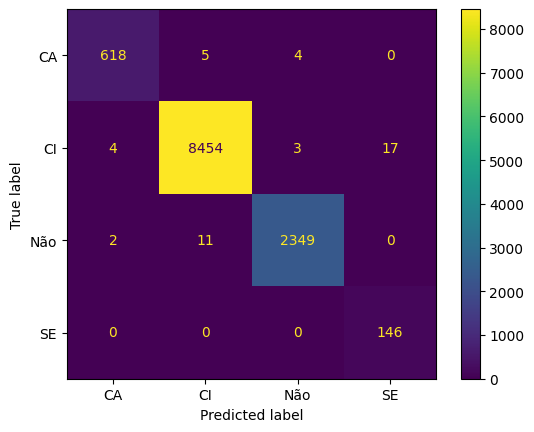

In [ ]:
# Métricas de avaliação da predição
print("F1-Score balanceado:", f1_score(df_test['categoria'], df_test['cat_pred'], average='weighted'))
print(classification_report(df_test['categoria'], df_test['cat_pred']))
ConfusionMatrixDisplay.from_predictions(df_test['categoria'], df_test['cat_pred'])

In [ ]:
# Listar as previsões erradas
df_error = df_test[df_test['categoria'] != df_test['cat_pred']]
print('Quantidade de previsões erradas:', df_error.shape[0])
df_error

Quantidade de previsões erradas: 46


,descricao_lematizada,fato_gerador,categoria,fg_pred,cat_pred
12,digitador setor contábil relacionar rede,Sim,CI,Sim,SE
444,aluquel social,Não,Não,Sim,CI
504,digitador setor contábil relacionar rede,Sim,CI,Sim,SE
710,servico prestar taxista segaf,Sim,CA,Sim,CI
740,digitador setor contábil relacionar rede,Sim,CI,Sim,SE
1512,transporte Kits alimentação escolar Escola marciano correo Miranda localidade felipequar em este,Sim,CA,Sim,CI
1940,loicacao lanchar voadeira Gabinete,Não,Não,Sim,CI
2164,eventual operador moto nivelador obra Transports,Sim,CA,Sim,CI
2547,digitador setor contábil relacionar rede,Sim,CI,Sim,SE
2839,p fazer face despesa material consumo Mascaras tecido combate novo coronavirus covid conforme contrato n,Não,Não,Sim,CI


## 4. Exportação dos melhores modelos

In [ ]:
# Exportação dos melhores modelos
joblib.dump(best_model, '/content/drive/My Drive/projeto classificacao de lancamento/modelos/reglog_best_model.pkl')
joblib.dump(best_model_1, '/content/drive/My Drive/projeto classificacao de lancamento/modelos/reglog_best_model_1.pkl')
joblib.dump(best_model_2, '/content/drive/My Drive/projeto classificacao de lancamento/modelos/reglog_best_model_2.pkl')

['/content/drive/My Drive/projeto classificacao de lancamento/modelos/reglog_best_model_2.pkl']

## 5. Avaliação do melhor modelo de 1 etapa com RepeatedStratifiedKFold

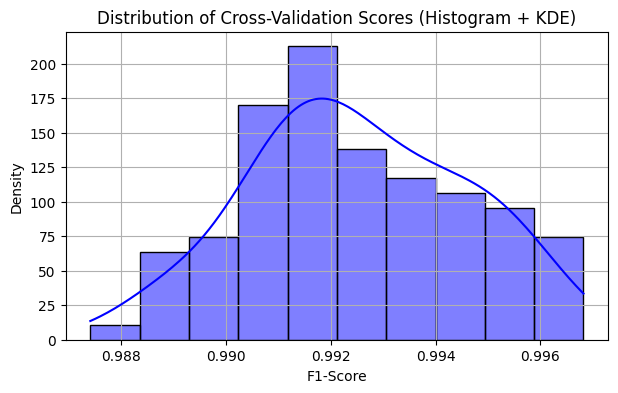

F1-Score médio: 0.992512
Desvio padrão: 0.002081
CPU times: user 29min 3s, sys: 1.71 s, total: 29min 4s
Wall time: 29min 17s


In [ ]:
%%time
X = df_sample['descricao_lematizada']
y = df_sample['categoria']

# Definição da estratégia de validação cruzada com 5 folds e 20 repetições e avaliação do modelo
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)
scores = cross_val_score(best_model, X, y, cv=cv, scoring='f1_weighted')

# Plotando o histograma dos scores com curva de densidade (KDE)
plt.figure(figsize=(7, 4))
sns.histplot(scores, kde=True, bins=10, color='blue', stat='density')
plt.title('Distribution of Cross-Validation Scores (Histogram + KDE)')
plt.xlabel('F1-Score')
plt.ylabel('Density')
plt.grid(True)
plt.show()
print(f"F1-Score médio: {np.mean(scores):.6f}")
print(f"Desvio padrão: {np.std(scores):.6f}")

## 6. Feature Importance

In [ ]:
# Monta Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Carrega as bibliotecas
import joblib
import pandas as pd

# Carrega o modelo de Regressão Logística com os melhores hiperparâmetros
reglog = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/reglog_best_model.pkl')

Mounted at /content/drive


In [ ]:
# Mostra as classes do modelo
print('Classes:', reglog.classes_)

# Recupera as etapas individuais do pipeline
classifier = reglog.named_steps['classifier']
tfidf = reglog.named_steps['tfidf']

# Recupera os coeficientes de cada classe
coef_CA = classifier.coef_[0]
coef_CI = classifier.coef_[1]
coef_NO = classifier.coef_[2]
coef_SE = classifier.coef_[3]

# Monta dataframe com o vocabulário da transformação TF-IDF
df_vocabulary = pd.DataFrame(tfidf.vocabulary_.keys(), index=tfidf.vocabulary_.values(), columns=['features'])
df_vocabulary.sort_index(inplace=True)
df_vocabulary.head()

Classes: ['CA' 'CI' 'Não' 'SE']


,features
0,2e
1,aa
2,aacutipereiro
3,abaetatuba
4,abaetetuba


In [ ]:
# Mostra as 10 palavras mais importantes para a classe CA (condutor autônomo).
df_CA = df_vocabulary.copy()
df_CA['coef_CA'] = coef_CA
df_CA.sort_values(by='coef_CA', ascending=False).head(10)

,features,coef_CA
4743,transporte,44.464080
2162,frete,39.462147
3629,pesar,19.122271
4621,taxi,18.611017
3628,pesado,17.577505
867,carro,16.063272
2161,fretamento,14.649568
4753,tratorista,14.147906
3447,otb,13.792183
1497,diaria,13.164534


In [ ]:
# Mostra as 10 palavras mais importantes para a classe CI (contribuinte individual).
df_CI = df_vocabulary.copy()
df_CI['coef_CI'] = coef_CI
df_CI.sort_values(by='coef_CI', ascending=False).head(10)

,features,coef_CI
1331,custeio,28.302227
3139,motorista,21.957785
2890,manutencao,18.688395
863,carregador,18.601062
699,bufe,18.580275
563,barqueiro,17.259976
1924,eventual,14.965352
126,agente,13.234596
2719,lavagem,13.048377
1115,confecção,11.334937


In [ ]:
# Mostra as 10 palavras mais importantes para a classe SE (segurado empregado).
df_SE = df_vocabulary.copy()
df_SE['coef_SE'] = coef_SE
df_SE.sort_values(by='coef_SE', ascending=False).head(10)

,features,coef_SE
3678,plantoes,29.115887
3679,plantonista,23.816955
3680,plantão,22.472449
3677,plantoe,19.017775
1163,contar,14.296813
3676,planto,13.736613
2291,gratificação,9.996630
1185,contábil,9.826878
943,chefe,8.811835
3683,platão,8.327159


In [ ]:
# Mostra as 10 palavras mais importantes para a classe Não (não é fato gerador).
df_NO = df_vocabulary.copy()
df_NO['coef_NO'] = coef_NO
df_NO.sort_values(by='coef_NO', ascending=False).head(10)

,features,coef_NO
2811,locação,63.999362
207,aluguel,54.638903
2798,locacao,48.511506
2126,fornecimento,32.201594
4107,remunerar,17.037350
2810,locaçao,16.902082
163,ajudar,16.211752
2367,hospedagem,15.386255
2371,hotelaria,13.781265
1029,colocação,13.305240


## 7. Demonstração do classificador

In [ ]:
# Carregamento dos dados de demonstração
df_demo = pd.read_excel('/content/drive/My Drive/projeto classificacao de lancamento/dados/demo.xlsx')
df_demo.head()

,Histórico
0,PAGAMENTO DO MÉDICO(A)DO PROGRAMA MAIS MÉDICOS...
1,PAGAMENTO DO MÉDICO(A)DO PROGRAMA MAIS MÉDICOS...
2,PAGAMENTO DO MÉDICO(A)DO PROGRAMA MAIS MÉDICOS...
3,PAGAMENTO DO MÉDICO(A)DO PROGRAMA MAIS MÉDICOS...
4,PAGAMENTO DO MÉDICO(A)DO PROGRAMA MAIS MÉDICOS...


### 6.1. Pré-processamento

In [ ]:
# Stopwords da biblioteca nltk em português
import nltk
import re
import spacy
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
spacy.cli.download("pt_core_news_sm")

# Configurações
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Stopwords
stop_words_nltk = stopwords.words('portuguese')
meses = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
corpus_stop_words = ['cameta', 'portel', 'laranjal', 'jari', 'garrafão', 'concordia', 'zona', 'rural', 'belém', 'pacaja', 'pacajar', 'anapu',
                     'aluno', 'mês', 'serviços', 'servicos', 'referente', 'prestados', 'prestados', 'pagamento', 'municipal', 'município', 'valor', 'empenha',
                     'favor', 'credor', 'acima', 'ocorrer', 'secretaria', 'ensino', 'mes', 'mês', 'durante', 'junto', 'atender', 'periodo', 'ref', 'm', '``']
stop_words = stop_words_nltk + meses + corpus_stop_words

In [ ]:
# Função para limpeza de texto
def limpa_texto(text, stop_words=[]):
    # Substitui sinais de pontuação por espaço em branco
    text = text.replace('.', ' ')
    text = text.replace(',', ' ')
    text = text.replace(';', ' ')
    text = text.replace(':', ' ')
    text = text.replace('!', ' ')
    text = text.replace('?', ' ')
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    text = text.replace('[', ' ')
    text = text.replace(']', ' ')
    text = text.replace('{', ' ')
    text = text.replace('}', ' ')
    text = text.replace('/', ' ')
    text = text.replace('-', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    text = ''.join(word for word in text if not word.isdigit()).lower()         # remove números e coloca em minúscula
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]                # stopwords
    return ' '.join(tokens)

In [ ]:
# Lematização
nlp = spacy.load('pt_core_news_sm')

def lematiza_spacy(texto):
    doc = nlp(texto)
    palavras_lemmatizadas = [token.lemma_ for token in doc]
    return ' '.join(palavras_lemmatizadas)

In [ ]:
# Aplicação das etapas de pré-processamento
df_demo['descricao_limpa'] = df_demo['Histórico'].apply(lambda x: limpa_texto(x, stop_words))
df_demo['descricao_lematizada'] = df_demo['descricao_limpa'].apply(lambda x: lematiza_spacy(x))
df_demo.head()

,Histórico,descricao_limpa,descricao_lematizada
0,PAGAMENTO DO MÉDICO(A)DO PROGRAMA MAIS MÉDICOS...,médico programa médicos brasil atua municipio ...,médico programa médico Brasil atuar Municipio ...
1,PAGAMENTO DO MÉDICO(A)DO PROGRAMA MAIS MÉDICOS...,médico programa médicos brasil atua municipio ...,médico programa médico Brasil atuar municipio ...
2,PAGAMENTO DO MÉDICO(A)DO PROGRAMA MAIS MÉDICOS...,médico programa médicos brasil atua municipio ...,médico programa médico Brasil atuar municipio ...
3,PAGAMENTO DO MÉDICO(A)DO PROGRAMA MAIS MÉDICOS...,médico programa médicos brasil atua municipio ...,médico programa médico Brasil atuar municipio ...
4,PAGAMENTO DO MÉDICO(A)DO PROGRAMA MAIS MÉDICOS...,médico programa médicos brasil atua municipio ...,médico programa médico Brasil atuar municipio ...


### 6.2. Treinamento e classificação

In [ ]:
# Demonstração da classificação do lançamento para novas observações
demo_sample = df_demo.sample(50, random_state=42)
X_demo = demo_sample['descricao_lematizada']

In [ ]:
y_pred = reglog.predict(X_demo)
demo_sample['categoria'] = y_pred
demo_sample[['Histórico', 'categoria']]

,Histórico,categoria
480,SERVIÇOS PRESTADOS A SECRETARIA DE SAÚDE NO CARGO DE MÉDICO NO POSTO DE SAÚDE DE MIRITITUBA DURANTE O MES DE JANEIRO DE 2024.,CI
449,"LOCAÇÃO DE IMOVEL LOCALIZADO NA COMUNIDADE DE AGUA BRANCA, PARA O FUNCIONAMENTO DA UBS REFERENTE AO MES DE JANEIRO/2024.",Não
475,SERVIÇOS PRESTADOS A SECRETARIA DE SAÚDE NO CARGO DE MÉDICO NAS AÇOES INTINERANTES NAS COMUNIDADES RIBEIRINHAS DURANTE O MES DE JANEIRO DE 2024.,CI
434,"DESTINADO PARA PAGAMENTO DE MEDICO DO PROGRAMA MAIS MÉDICO QUE ATUA NO MUNICIPIO DE ITAITUBA/PA(BELA VISTA),REFERENTE AO MÊS DE FEVEREIRO DE 2024.",CI
368,"Destinado para pagamento do médico LUIZ TOMAZ DE ALMEIDA SANTOS do pragrama Mais Médico que atua no municipio de Itaituba (CREPURIZINHO), de acordo com a portaria GAB/PMI 282/2019, referente ao mês de MARÇO/2024.",CI
55,"PAGAMENTOS DE SERVIÇOS PRESTADOS À SECRETARIA DE SAÚDE NO CARGO DE MÉDICO NO CENTRO DE SAÚDE DE MIRITITUBA,DURANTE O MÊS DE JUNHO DE 2024.",CI
322,"DIARIAS DE SERVIÇOS DE TRANSPORTE ESCOLAR FLUVIAL, TIPO LANCHA MOTOR NA ROTA 19: CAKWATPU, EMEF DATIE BI¦VY, EMEF SAW EXUMBU E EMEF SAWRE BAAY, PARA DISTRIBUIÇÃO DE MERENDA NAS ESCOLAS INDIGENAS,REFERENTE AO MES DE FEVEREIRO 2024.",CA
76,"DIARIAS DE SERVIÇO DE TRANSPORTE ESCOLAR FLUVIAL, TIPO LANCHA MOTOR, NA ROTA 01: COMUNIDADE NOVO PARAISO/CASTANHO/LAGO DO PAGÃO/LAGO DE ADÃO/ INDEPENDENCIA II, NO MUNICIPIO DE ITAITUBA, ESTADO DO PARÁ, PARA ATENDER OS ALUNOS LOTADOS NA ESCOLA NOVO PARAISO.",CA
504,SERVIÇOS PRESTADOS A SEMSA NO CARGO DE MÉDICO PLANTONISTA NO HMI DURANTE O MES DE JANEIRO DE 2024.,SE
347,"DIARIAS DE SERVIÇO DE TRANSPORTE ESCOLAR FLUVIAL, TIPO LANCHA MOTOR NA ROTA 05: VILA BRAGA/ILHA DA GOIANA/VILA RAYOL, NO MUNICIPIO DE ITAITUBA, ESTADO DO PARÁ, PARA ATENDER OS ALUNOS LOTADOS NA ESCOLA SAO RAIMUNDO I, REFERENTE AO MES DE JANEIRO DE 2024.",CI
